# Creating Machine learning Model to Predict Presence of Coronary Artery Disease
### Group 35 analysis

## 1. SUMMARY

The following document covers a machine learning model analysis with a goal to predict angiographic coronary disease in patients. Data is pulled from patients undergoing angiography at the Cleveland Clinic in Ohio. This analysis is composed of Exploratory Data Analysis, testing of various machine models on a training data set, model optimization via hyperparameter, and final model performance analysis. The final model is shown to have promising results, though limitations apply and further testing and optimization is recommended.


## 2. INTRODUCTION
Heart disease is the leading cause of death worldwide. Treating these heart diseases depends on capability of detecting symptoms and diagnosing cases earlier. One complication to diagnosing heart diseases is that many cases are found to be aymptomatic (Master et al, 1969). This creates an opportunity for application of machine learning methods, where the following question can be asked: Given various details about a clients medical status, can we create a statistical model to accurately predict whether the patient has the disease? The goal of the following analysis is to create a model that can anwswer this question. To be best suited to the problem, the model should retain a high accuracy while minimizing the number of false negatives (ie predicting that a patient does not have the heart disease when the patient in fact does.

In particular, this analysis focuses on detection of angiographic coronary disease. The data set used in creating our model was taken from 303 patients undergoing angiography Cleveland Clinic in Cleveland, Ohio (Janosi et al, 1989). from this procedure, a set of parameters were collected about each patients, and a diagnosis of whether the patient had the angiographic coronary disease (signified by a diameter narrowing of the coronary artery by at least 50%). This is to serve as the target variable in our analysis

The set of parameters collected during the procedure, used as our features for model training, are as follows:

- **Age (in years)** : Age of patient (years)
- **Sex** : Sex of patient (male or female)
- **Chest pain type**: categorical feature describing the type of pain experienced by the patient
- **Resting Blood Pressure**: numeric feature giving patients resting blood pressure
- **Serum Cholesterol** : numneric feature giving the patients Serum cholesterol in mg/dl
- **Fasting blood sugar > 120 mg/dl** : binary feature indicating whether the patients Blood sugar level while fasting exceeded 120 mg/dl
- **Resting electrocardiographic results**:  categorical feature reporting patients ECG results
- **Maximum heart rate achieved**: numeric feature giving maximum heart rate achieved by patent
- **Exercise-induced angina**: binary feature indicating whether patient underwent exercise induced angina
- **ST depression induced by exercise relative to rest**: numeric feature indicating the ST depression induced by exercise relative to rest
- **Slope of the peak exercise ST segment**
- **Thalassemia** : categorical feature indicating if patient suffered from Thalassemia



The following sections will discuss the decisions made and results in our Exploratory Data analysis, Machine learning model training, and final model performance

### IMPORTS

In [1]:
import numpy as np
import pandas as pd 
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import altair_ally as aly
import pandera as pa
from scipy import stats
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from deepchecks.tabular.checks import FeatureDrift

## 3. DATA VALIDATION & CLEANING

The purpose of this section is to ensure that the data is clean ahead of EDA and modelling. We will use Pandera, Deepchecks, and SciPy packages to evaluate data quality and drop rows as needed.

First, we will evaluate the data file format. The file is in CSV format which will be suitable for import and conversion to a pandas dataframe. Upon initial inspection of the csv, the data is in tidy format.

In [2]:
df = pd.read_csv("data/raw/pretransformed_heart_disease.csv")
df.head()

,Age (in years),Sex,Chest pain type,Resting blood pressure (in mm Hg on admission to the hospital),Serum cholesterol (in mg/dl),Fasting blood sugar > 120 mg/dl,Resting electrocardiographic results,Maximum heart rate achieved,Exercise-induced angina,ST depression induced by exercise relative to rest,Slope of the peak exercise ST segment,Number of major vessels (0–3) colored by fluoroscopy,Thalassemia,Diagnosis of heart disease
0,63,male,typical angina,145,233,True,showing probable or definite left ventricular ...,150,no,2.3,downsloping,0.0,fixed defect,0
1,67,male,asymptomatic,160,286,False,showing probable or definite left ventricular ...,108,yes,1.5,flat,3.0,normal,2
2,67,male,asymptomatic,120,229,False,showing probable or definite left ventricular ...,129,yes,2.6,flat,2.0,reversable defect,1
3,37,male,non-anginal pain,130,250,False,normal,187,no,3.5,downsloping,0.0,normal,0
4,41,female,atypical angina,130,204,False,showing probable or definite left ventricular ...,172,no,1.4,upsloping,0.0,normal,0


### INITIAL DATA CLEANING
From an initial preview of the data, we see there are some issues we can correct immediately, before performing formal data validation. This includes:
1. Removing invalid target values (i.e. values above 2) and converting the values to their semantic meaning.

In [3]:
df = df[df['Diagnosis of heart disease'] <= 1]
df['Diagnosis of heart disease'] = df['Diagnosis of heart disease'].replace(
    {0: '< 50% diameter narrowing', 1: '> 50% diameter narrowing'})

In [4]:
#Validation data step: 
# - check correct column types, 
# - check missingess threshold for most columns, 
# - check correct expected values for categorical columns
# - remove unexpected values

schema = pa.DataFrameSchema(
    {
        "Age (in years)": pa.Column(int,
                                    pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                        element_wise=False,
                                        error="Too many null values in column."), 
                                    nullable=True),
        "Sex": pa.Column(str,pa.Check.isin(["male", "female"])),
        "Chest pain type": pa.Column(str, pa.Check.isin(["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"])),
        "Resting blood pressure (in mm Hg on admission to the hospital)": pa.Column(int,
                                                                            pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                                                                element_wise=False, 
                                                                                error="Too many null values in column."), 
                                                                            nullable=True),
        "Serum cholesterol (in mg/dl)": pa.Column(int,
                                            pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                                element_wise=False, 
                                                error="Too many null values in column."), 
                                            nullable=True),
        "Fasting blood sugar > 120 mg/dl": pa.Column(bool,
                                                pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                                    element_wise=False, 
                                                    error="Too many null values in column."), 
                                                nullable=True),
        "Resting electrocardiographic results": pa.Column(str,pa.Check.isin(["normal", 
                                                                             "having ST-T wave abnormality", 
                                                                             "showing probable or definite left ventricular hypertrophy by Estes' criteria"])),
        "Maximum heart rate achieved": pa.Column(int,
                                            pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                                element_wise=False, 
                                                error="Too many null values in column."), 
                                            nullable=True),
        "Exercise-induced angina": pa.Column(str, pa.Check.isin(["yes","no"])),
        "ST depression induced by exercise relative to rest": pa.Column(float,
                                                                pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                                                    element_wise=False, 
                                                                    error="Too many null values in column."), 
                                                                nullable=True),
        "Slope of the peak exercise ST segment": pa.Column(str, pa.Check.isin(["upsloping", "flat", "downsloping"])),
        "Number of major vessels (0–3) colored by fluoroscopy": pa.Column(float,
                                                                    pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                                                    element_wise=False, 
                                                                    error="Too many null values in column."),
                                                                nullable=True),
        "Thalassemia": pa.Column(str, 
                                 pa.Check(lambda s: s.isna().mean() <= 0.05, 
                                        element_wise=False, 
                                        error="Too many null values in column."),
                                    nullable=True),
        "Diagnosis of heart disease": pa.Column(str, pa.Check.isin(["< 50% diameter narrowing", "> 50% diameter narrowing"]))
    } ,
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found.")
    ],
    drop_invalid_rows=True
)

df = schema.validate(df, lazy = True)
df


,Age (in years),Sex,Chest pain type,Resting blood pressure (in mm Hg on admission to the hospital),Serum cholesterol (in mg/dl),Fasting blood sugar > 120 mg/dl,Resting electrocardiographic results,Maximum heart rate achieved,Exercise-induced angina,ST depression induced by exercise relative to rest,Slope of the peak exercise ST segment,Number of major vessels (0–3) colored by fluoroscopy,Thalassemia,Diagnosis of heart disease
0,63,male,typical angina,145,233,True,showing probable or definite left ventricular ...,150,no,2.3,downsloping,0.0,fixed defect,< 50% diameter narrowing
2,67,male,asymptomatic,120,229,False,showing probable or definite left ventricular ...,129,yes,2.6,flat,2.0,reversable defect,> 50% diameter narrowing
3,37,male,non-anginal pain,130,250,False,normal,187,no,3.5,downsloping,0.0,normal,< 50% diameter narrowing
4,41,female,atypical angina,130,204,False,showing probable or definite left ventricular ...,172,no,1.4,upsloping,0.0,normal,< 50% diameter narrowing
5,56,male,atypical angina,120,236,False,normal,178,no,0.8,upsloping,0.0,normal,< 50% diameter narrowing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,41,male,atypical angina,120,157,False,normal,182,no,0.0,upsloping,0.0,normal,< 50% diameter narrowing
297,57,female,asymptomatic,140,241,False,normal,123,yes,0.2,flat,0.0,reversable defect,> 50% diameter narrowing
298,45,male,typical angina,110,264,False,normal,132,no,1.2,flat,0.0,reversable defect,> 50% diameter narrowing
301,57,female,atypical angina,130,236,False,showing probable or definite left ventricular ...,174,no,0.0,flat,1.0,normal,> 50% diameter narrowing


In [5]:
# Checking work - delete when data validation complete     
# checks=[
#         pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
#         pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found.")
#     ]


# ,
#                                     pa.Check(lambda s: s.isna().mean() <= 0.05, 
#                                         element_wise=False, 
#                                         error="Too many null values in column."), 
#                                     nullable=True


#         "Number of major vessels (0–3) colored by fluoroscopy": pa.Column(float,
#                                                                     pa.Check(
#                                                                         lambda s: s.between(0,3).all() and s.isna().mean() <= 0.05,  # Combined check
#                                                                         error="Invalid value or too many null values in column."
#                                                                         ), 
#                                                                     nullable=True),

In [6]:
# # rename target classes
# df['Diagnosis of heart disease'] = df['Diagnosis of heart disease'].replace({0: '< 50% diameter narrowing', 1: '> 50% diameter narrowing'})
# df

In [7]:
#verify correlations - Feature-target:
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation

heart_disease_ds = Dataset(df, label="Diagnosis of heart disease", cat_features=['Sex','Chest pain type','Fasting blood sugar > 120 mg/dl','Resting electrocardiographic results','Exercise-induced angina','Slope of the peak exercise ST segment','Thalassemia'])

In [8]:
check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=heart_disease_ds)

In [9]:
#verify correlations: feature-feature:
# reference: https://docs.deepchecks.com/stable/tabular/auto_checks/data_integrity/plot_feature_feature_correlation.html#sphx-glr-tabular-auto-checks-data-integrity-plot-feature-feature-correlation-py

from deepchecks.tabular.datasets.classification import adult
from deepchecks.tabular.checks.data_integrity import FeatureFeatureCorrelation

check = FeatureFeatureCorrelation()
# check.run(df)

check.add_condition_max_number_of_pairs_above_threshold(0.8, 3)
result = check.run(df)
result.show(show_additional_outputs=False)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 9 categorical features were inferred.: Sex, Chest pain type, Fasting blood sugar > 120 mg/dl, Resting electrocardiographic results, Exercise-induced angina, Slope of the peak exercise ST segment, Number of major vessels (0–3) colored by fluoroscopy... For full list use dataset.cat_features


Next, we will evaluate whether the features in the train and test dataset are distributed similarly using deepchecks.

In [10]:
train_df, test_df = train_test_split(df, test_size=0.1)

X_train = train_df.drop('Diagnosis of heart disease', axis=1)
y_train = train_df['Diagnosis of heart disease']
X_test = test_df.drop('Diagnosis of heart disease', axis=1)
y_test = test_df['Diagnosis of heart disease']

In [11]:
train_ds = Dataset(train_df, label="Diagnosis of heart disease", cat_features=['Sex','Chest pain type',
                                                                               'Fasting blood sugar > 120 mg/dl',
                                                                               'Resting electrocardiographic results',
                                                                               'Exercise-induced angina',
                                                                               'Slope of the peak exercise ST segment',
                                                                               'Thalassemia'])
test_ds = Dataset(test_df, label="Diagnosis of heart disease", cat_features=['Sex','Chest pain type',
                                                                           'Fasting blood sugar > 120 mg/dl',
                                                                           'Resting electrocardiographic results',
                                                                           'Exercise-induced angina',
                                                                           'Slope of the peak exercise ST segment',
                                                                           'Thalassemia'])
check = FeatureDrift()
result = check.run(train_dataset=train_ds, test_dataset=test_ds)
result.value

{'Age (in years)': {'Drift score': 0.13751730502999537,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Sex': {'Drift score': 0.0, 'Method': "Cramer's V", 'Importance': None},
 'Chest pain type': {'Drift score': 0.0,
  'Method': "Cramer's V",
  'Importance': None},
 'Resting blood pressure (in mm Hg on admission to the hospital)': {'Drift score': 0.24019381633594827,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Serum cholesterol (in mg/dl)': {'Drift score': 0.14951545916012915,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Fasting blood sugar > 120 mg/dl': {'Drift score': 0.0,
  'Method': "Cramer's V",
  'Importance': None},
 'Resting electrocardiographic results': {'Drift score': 0.0,
  'Method': "Cramer's V",
  'Importance': None},
 'Maximum heart rate achieved': {'Drift score': 0.27711121365943703,
  'Method': 'Kolmogorov-Smirnov',
  'Importance': None},
 'Exercise-induced angina': {'Drift score': 0.0,
  'Method': "Cramer's V",
  'Importance': N

From the output above, we can see that the features have not distributed significantly and our distributions are as expected.

## 4. METHOD

The following section outlines the steps taken in manipulating our data and creating our model.

EDA is first conducted to obtain an idea of feature importance and to establish any important correlations to watch for.

Machine learning analysis is then performed, where multiple models are tested and their performance compared. The best performing model is selected to proceed with. On this model, hyperparameter test is completed via random search to tune our model and obtain best results. Finally, the model is trained and tested on a separate data set, and evaluated for performance.

### 4.1 EDA

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Age (in years)                                                  219 non-null    int64  
 1   Sex                                                             219 non-null    object 
 2   Chest pain type                                                 219 non-null    object 
 3   Resting blood pressure (in mm Hg on admission to the hospital)  219 non-null    int64  
 4   Serum cholesterol (in mg/dl)                                    219 non-null    int64  
 5   Fasting blood sugar > 120 mg/dl                                 219 non-null    bool   
 6   Resting electrocardiographic results                            219 non-null    object 
 7   Maximum heart rate achieved                               

In [13]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [14]:
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('html')

RendererRegistry.enable('html')

In [15]:
# Univariate distrbution for the quantitative variables
numeric_columns = [
    'age_(in_years)',
    'resting_blood_pressure_(in_mm_hg_on_admission_to_the_hospital)',
    'serum_cholesterol_(in_mg/dl)',
    'maximum_heart_rate_achieved',
    'st_depression_induced_by_exercise_relative_to_rest',
    'number_of_major_vessels_(0–3)_colored_by_fluoroscopy'
]

aly.alt.data_transformers.enable('vegafusion')


aly.dist(df[numeric_columns + ['diagnosis_of_heart_disease']], color='diagnosis_of_heart_disease')

alt.ConcatChart(...)

**Analysis of Quantitative Variables**

**1. Maximum Heart Rate Achieved**
- Patients with `<50% diameter narrowing` have higher maximum heart rates compared to `>50% diameter narrowing`.
- Severe heart disease may reduce maximum heart rate capabilities.

**2. Serum Cholesterol (mg/dL)**
- Distributions are similar across both groups.
- Cholesterol alone may not distinguish heart disease severity.

**3. Resting Blood Pressure (mm Hg)**
- Slightly higher resting blood pressure observed in `>50% diameter narrowing`.
- May not be a strong independent predictor due to overlap.
**4. Age (Years)**
- Older patients are more likely to belong to the `>50% diameter narrowing` group.
- Age is a potential risk factor for severe heart disease.

**5. Number of Major Vessels Colored by Fluoroscopy**
- Patients with `<50% diameter narrowing` tend to have fewer major vessels affected compared to those with `>50% diameter narrowing`.
- This variable may serve as a significant indicator for heart disease severity.

**6. ST Depression Induced by Exercise**
- Patients with `>50% diameter narrowing` exhibit higher ST depression levels.
- Suggests stronger ischemic responses during exercise in patients with severe heart disease.


In [16]:
categorical_columns = [
    'sex', 
    'chest_pain_type', 
    'fasting_blood_sugar_>_120_mg/dl', 
    'resting_electrocardiographic_results',
    'exercise-induced_angina', 
    'slope_of_the_peak_exercise_st_segment', 
    'thalassemia'
]

# Visualize the distributions for the categorical variables colored by 'diagnosis_of_heart_disease'
aly.dist(
    df[categorical_columns + ['diagnosis_of_heart_disease']]
    .assign(diagnosis_of_heart_disease=lambda x: x['diagnosis_of_heart_disease'].astype(object)), 
    dtype='object', 
    color='diagnosis_of_heart_disease'
)

alt.ConcatChart(...)

**Analysis of Categorical Variables**

**1. Sex**
- Males dominate both groups, but females are more prevalent in `<50% diameter narrowing`.

**2. Exercise-Induced Angina**
- `No angina` is more common in `<50%`, while `Yes angina` is prominent in `>50%`.

**3. Resting Electrocardiographic Results**
- `Normal` results dominate `<50%`, while `ST-T wave abnormality` is common in `>50%`.

**4. Slope of the Peak Exercise ST Segment**
- `Upsloping` is frequent in `<50%`, whereas `Flat slope` is linked to `>50%`.

**5. Thalassemia**
- `Normal` is prevalent in `<50%`, and `Reversible defect` is more frequent in `>50%`.

**6. Chest Pain Type**
- `Asymptomatic` pain is common in `>50%`, while other types are evenly distributed.



In [17]:
# Visualize pairwise correlations for the quantitative variables
aly.corr(df[numeric_columns])

alt.ConcatChart(...)

- **Maximum Heart Rate Achieved:**
  - Negatively correlated with `age (in years)` in both Pearson and Spearman correlations, suggesting that maximum heart rate decreases with age.
- **Serum Cholesterol (in mg/dL):**
  - Weak correlations with other variables, indicating that cholesterol may not strongly relate to other numeric features.
- **Resting Blood Pressure (in mm Hg):**
  - Slight positive correlation with `age (in years)` but weak overall relationships with other variables.

- **Strongest Correlation:**
  - Maximum heart rate achieved shows the most meaningful relationship, particularly with age.
- **Weak Predictors:**
  - Serum cholesterol and resting blood pressure exhibit weak correlations across variables.


In [18]:
# Select numeric columns with high correlations
columns_with_at_least_one_high_corr = [
    'age_(in_years)',
    'resting_blood_pressure_(in_mm_hg_on_admission_to_the_hospital)',
    'serum_cholesterol_(in_mg/dl)',
    'maximum_heart_rate_achieved',
    'st_depression_induced_by_exercise_relative_to_rest',
    'number_of_major_vessels_(0–3)_colored_by_fluoroscopy',
    'diagnosis_of_heart_disease'
]

sample_size = min(len(df), 300)

aly.pair(
    df[columns_with_at_least_one_high_corr].sample(sample_size),
    color='diagnosis_of_heart_disease'
)

alt.VConcatChart(...)

- **Age vs. Maximum Heart Rate Achieved:**
  - A negative trend is visible, with older individuals achieving lower maximum heart rates.
  - This relationship appears consistent across both `<50%` and `>50% diameter narrowing`.

- **Resting Blood Pressure vs. Age:**
  - Weak positive trend suggesting older individuals might have slightly higher resting blood pressure.
  - The distribution overlaps significantly between `<50%` and `>50% diameter narrowing`.

- **Serum Cholesterol vs. Resting Blood Pressure:**
  - No clear trend is visible, indicating little to no relationship between these variables.

- **Serum Cholesterol vs. Diagnosis:**
  - Overlapping distributions suggest serum cholesterol is not a strong differentiator for heart disease severity.

**Insights:**
- **Strongest Patterns:**
  - The negative correlation between age and maximum heart rate achieved is notable.
- **Weak Predictors:**
  - Serum cholesterol and resting blood pressure show weak or no significant trends.


## 4.2 ML-Analysis

The following section outlines the procedure taken in creating our model and testing it on our data set.
As this is a classification problem (predict whether the patient has the disease or not), the chosen models for testing in this analyis are a Logistic Regression model and a Suport Vector Classifier. These two models were selected as they have been shown to historically perform well on real world data sets.

Since this data set is somewhat unbalanced (~80/20 split on non-disease vs disease), the primary scoring metric to evaluate these models will be F1 score, though model accuracy is still taken into consideration. Due to the nature of the analysis, special attention is taken to minimize false negatives as they represent the most damaging type of error (predicting that a patient is free of the disease when he does in fact have it). To this effect, we look to maximize Recall.

The framework upon which this analysis is based has been adapted from DSCI573 Lab1.

### 4.2.2. Data Preprocessing
Features are sorted by type, and a column transformer object is created. on categorical columns, simple imputing is applied filling missing values with the most frequently occuring value. One hot encoding is then performed. 

For numerical feature, standard scaling is applied to keep all features within the same range

In [19]:
# Lists of feature names
categorical_features = ['Sex', 
                        'Chest pain type', 
                        'Fasting blood sugar > 120 mg/dl', 
                        'Resting electrocardiographic results', 
                        'Exercise-induced angina', 
                        'Slope of the peak exercise ST segment', 
                        'Thalassemia']
numeric_features = list(set(X_train.columns) - set(categorical_features))

# Create transformer pipeline
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", drop='if_binary', dtype=int, sparse_output=False),
)

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median", fill_value="missing"),
    StandardScaler(),
)

# Create the column transformer
preprocessor = make_column_transformer(
    (categorical_transformer, categorical_features),
    (numeric_transformer, numeric_features),
)
# Show the preprocessor
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Chest pain type',
                                  'Fasting blood sugar > 120 mg/dl',
                                  'Resting electrocardiographic results',
                                  'Exer...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Resting blood pressure (in mm Hg on '
                                  'admission to the hospital)',
                                  'Age (in years)',
                                  'Number of major vessels (0–3) colored by '
                                  'fluoroscopy',
                                  'ST depression induced by exercise relative '
                                  'to rest',
                                  'Serum cholesterol (in mg/dl)',
                                  'Maximum heart rate achieved'])])

### 4.2.3. model creation

Basic models (default hyperparameter values) are now generated. A dummy model is first created to use as a baseline to use for comparison. Then, a logistic regressor and support vector classifier model is created. 5-fold cross validation (CV) is performed on each model and scores are returned.

As discussed above, F1 score is to be the primary metric to evaluate model performance, with precision as a secondary metric. this is reflected in the scoring metrics used in CV

Finally, a Confusion matrix is generated for each model to give an idea of false positive vs false negative rate. 

In [20]:
# 0. Dummy model
# Imports
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (make_scorer, 
                            precision_score,
                            recall_score,
                            f1_score)

classification_metrics = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, pos_label='> 50% diameter narrowing'),
    "recall": make_scorer(recall_score, pos_label='> 50% diameter narrowing'),
    "f1": make_scorer(f1_score, pos_label='> 50% diameter narrowing'),
}

# The dummy model
dc = make_pipeline(DummyClassifier())
# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results = {}
cross_val_results['dummy'] = pd.DataFrame(cross_validate(dc, 
                                                         X_train, 
                                                         y_train, 
                                                         cv=5, 
                                                         scoring=classification_metrics,
                                                         )).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['dummy']

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.11/site-packages/sklearn/

,mean,std
fit_time,0.001,0.000
score_time,0.006,0.001
test_accuracy,0.751,0.011
test_precision,0.000,0.000
test_recall,0.000,0.000
test_f1,0.000,0.000


In [21]:
# 1. Logistic Regression model

# The logreg model pipeline
logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=1000))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['logreg'] = pd.DataFrame(cross_validate(logreg, 
                                                          X_train, 
                                                          y_train, 
                                                          cv=5, 
                                                          scoring=classification_metrics, 
                                                          return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg'] 

,mean,std
fit_time,0.033,0.017
score_time,0.020,0.005
test_accuracy,0.802,0.072
train_accuracy,0.860,0.016
test_precision,0.718,0.237
train_precision,0.811,0.047
test_recall,0.471,0.157
train_recall,0.571,0.048
test_f1,0.538,0.138
train_f1,0.670,0.045


In [22]:
# 2. Support vector classifier
# Imports
from sklearn.svm import SVC

# The svc model pipeline
svc = make_pipeline(preprocessor, SVC(random_state=123))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['svc'] = pd.DataFrame(cross_validate(svc, 
                                                      X_train, 
                                                      y_train, 
                                                      cv=5, 
                                                      scoring=classification_metrics, 
                                                      return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['svc'] 

,mean,std
fit_time,0.016,0.005
score_time,0.012,0.003
test_accuracy,0.827,0.030
train_accuracy,0.892,0.016
test_precision,0.870,0.186
train_precision,0.990,0.021
test_recall,0.367,0.047
train_recall,0.571,0.062
test_f1,0.514,0.078
train_f1,0.723,0.051


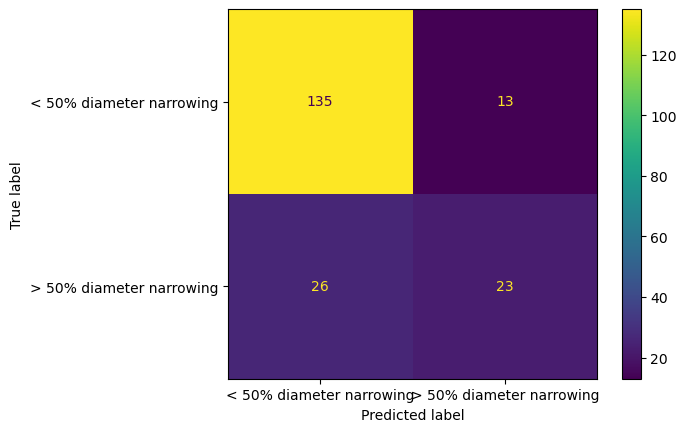

In [23]:
# 3. Confusion matrix for the logistic regression
# Imports
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

confmat_logreg = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(logreg, X_train, y_train),
    values_format='d'
)
# Show the matrix
confmat_logreg

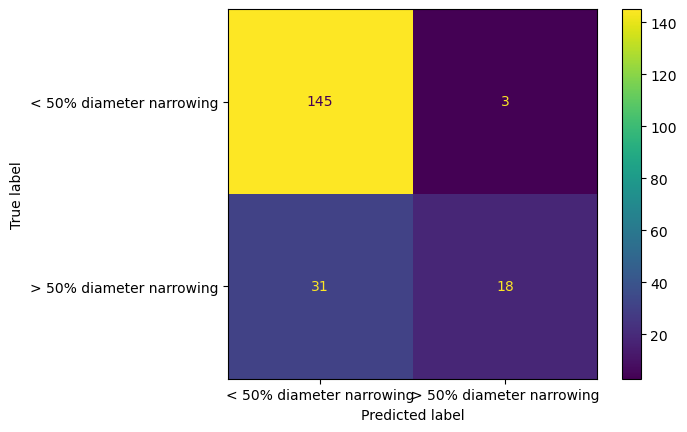

In [24]:
# 3. Confusion matrix for the SVC
confmat_svc = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(svc, X_train, y_train),
    values_format='d',
)
# Show the matrix
confmat_svc

### 4.2.4. Balanced model testing

Step 3.2.3 is repeated, this time creating balanced logistic regressor and SVC  models, with all other hyperparameters held the same. Confusion matrices are once again generated. The goal of this step is to gain an understanding of how much accuracy is sacrificed at the benefit of improving F1 score.

In [25]:
# 4. Balanced logistic regression
# The logreg model pipeline
logreg_bal = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=1000, class_weight="balanced"))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['logreg_bal'] = pd.DataFrame(cross_validate(logreg_bal, 
                                                        X_train, 
                                                        y_train, 
                                                        cv=5, 
                                                        scoring=classification_metrics,
                                                        return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['logreg_bal'] 

,mean,std
fit_time,0.022,0.008
score_time,0.013,0.003
test_accuracy,0.756,0.087
train_accuracy,0.811,0.022
test_precision,0.526,0.140
train_precision,0.583,0.030
test_recall,0.713,0.051
train_recall,0.842,0.066
test_f1,0.601,0.110
train_f1,0.688,0.040


In [26]:
# 5. Balanced support vector classifier
# The svc model pipeline
svc_bal = make_pipeline(preprocessor, SVC(random_state=123, class_weight="balanced"))

# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results['svc_bal'] = pd.DataFrame(cross_validate(svc_bal, 
                                                          X_train, 
                                                          y_train, 
                                                          cv=5, 
                                                          scoring=classification_metrics, 
                                                          return_train_score=True)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['svc_bal'] 

,mean,std
fit_time,0.012,0.002
score_time,0.009,0.001
test_accuracy,0.725,0.080
train_accuracy,0.925,0.007
test_precision,0.480,0.098
train_precision,0.790,0.022
test_recall,0.653,0.087
train_recall,0.954,0.028
test_f1,0.547,0.078
train_f1,0.864,0.011


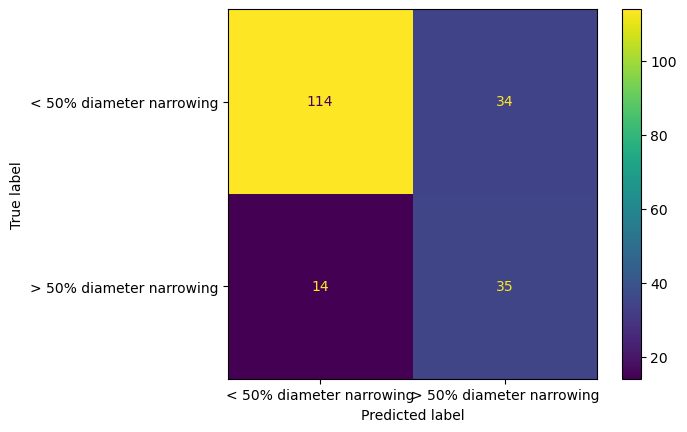

In [27]:
# 6. Confusion matrix for the balanced logistic regression

confmat_logreg_bal = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(logreg_bal, X_train, y_train),
    values_format='d'
)
# Show the matrix
confmat_logreg_bal

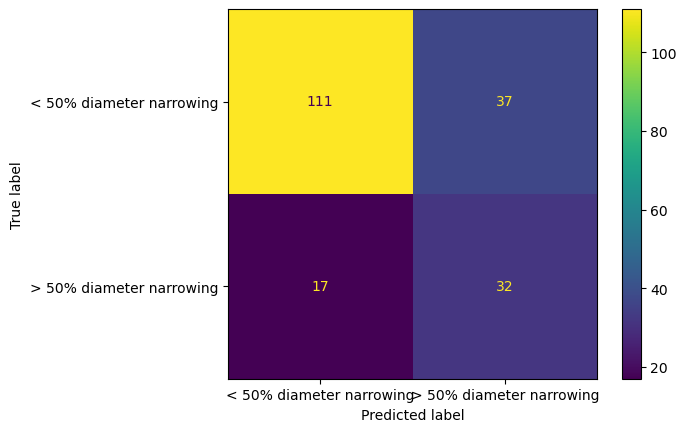

In [28]:
# 6. Confusion matrix for the balanced SVC
confmat_svc_bal = ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(svc_bal, X_train, y_train),
    values_format='d'
)
# Show the matrix
confmat_svc_bal

### 4.2.5. Model Evaluation

With baseline models created, they are evaluated according to the criteria set above. CV scores of each model are presented below. First, standard deviation is shown verify there are no abnormally performing models. Scores are then presented in the table below

In [29]:
# Manual check that the cross val std doesn't look way off for some model
pd.concat(
    cross_val_results,
    axis='columns'  # Get the right model names and mean/std as columns
).xs(
    'std',  # Select only the 'std' columns
    axis='columns',  # Cross-section the columns
    level=1  # The 1st level ('mean', 'std') instead of the 0th level (the model names)
).style.format(
    precision=2  # Pandas `.style` does not honor previous rounding via `.round()`
).background_gradient(
    axis=None  # Color cells based on the entire matrix rather than row/column-wise
)

,dummy,logreg,svc,logreg_bal,svc_bal
fit_time,0.00,0.02,0.01,0.01,0.00
score_time,0.00,0.01,0.00,0.00,0.00
test_accuracy,0.01,0.07,0.03,0.09,0.08
test_precision,0.00,0.24,0.19,0.14,0.10
test_recall,0.00,0.16,0.05,0.05,0.09
test_f1,0.00,0.14,0.08,0.11,0.08
train_accuracy,nan,0.02,0.02,0.02,0.01
train_precision,nan,0.05,0.02,0.03,0.02
train_recall,nan,0.05,0.06,0.07,0.03
train_f1,nan,0.04,0.05,0.04,0.01


In [30]:
# Compare the average scores of all the models
pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=2
).background_gradient(
    axis=None
)

,dummy,logreg,svc,logreg_bal,svc_bal
fit_time,0.00,0.03,0.02,0.02,0.01
score_time,0.01,0.02,0.01,0.01,0.01
test_accuracy,0.75,0.80,0.83,0.76,0.72
test_precision,0.00,0.72,0.87,0.53,0.48
test_recall,0.00,0.47,0.37,0.71,0.65
test_f1,0.00,0.54,0.51,0.60,0.55
train_accuracy,nan,0.86,0.89,0.81,0.93
train_precision,nan,0.81,0.99,0.58,0.79
train_recall,nan,0.57,0.57,0.84,0.95
train_f1,nan,0.67,0.72,0.69,0.86


### Model evaluation and selection
Comparing the metrics across models, Balanced logistic regression yields the highest recall and with second to the highest f1_score. For this report, we choose to proceed with `LogisticRegression(class_weight="balanced")` and optimize the f1 score metric along with optimizing recall as we want to minimize False Negatives, which is more damaging in medical diagnosis than False Positives

### 4.2.6. Hyperparameter optimization

Proceeding with a balanced logistic regressor model, we now perform hyperparameter optimization. Logistic regressors has only one hyperparameter C, which is sampled from a loguniform distribution. optimization is based on F1 score

In [31]:
# Hyperparameter optimization f1
import numpy as np

# Define parameter distributions
param_distributions = {
    'logisticregression__C': np.logspace(-5, 5, 50),  # Regularization strength
}

custom_scorer = make_scorer(f1_score, pos_label='> 50% diameter narrowing')

random_search = RandomizedSearchCV(logreg_bal, param_distributions=param_distributions,
                                    n_iter=100, n_jobs= -1,
                                    scoring=custom_scorer,
                                    return_train_score=True,
                                    random_state=123)

random_search.fit(X_train, y_train)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.



RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(drop='if_binary',
                                                                                                              dtype=<class 'int'>,
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['Sex',
                                                                                'Chest '
                                                                                'pain '
                                                                                'type',
                                                                                '...
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
                   random_state=123, return_train_score=True,
                   scoring=make_scorer(f1_score, pos_label=> 50% diameter narrowing))

In [32]:
# Extract cv_results_ into a DataFrame
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.sort_values(by='rank_test_score').head(3)
top_results = top_results[[
    'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'params', 
]]

# Set pandas options to display all column content
pd.set_option('display.max_colwidth', None)
top_results

,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,params
20,0.644673,0.044694,0.620260,0.119373,0.076075,{'logisticregression__C': 0.1206792640639329}
19,0.637179,0.041233,0.608662,0.134769,0.071545,{'logisticregression__C': 0.07543120063354623}
22,0.653636,0.028063,0.604987,0.121207,0.070797,{'logisticregression__C': 0.30888435964774846}


### Hyperparameter optimization results
The hyperparameter optimization made a difference **('mean_test_score' (0.58) compared to 'mean_test_score of cross' (0.54) of previous mean validation score)**. However, the cross-validation scores among the top three models are approximately equivalent. This suggests that the model's performance is relatively stable across the parameter space, indicating that further tuning may not yield substantial improvements.

### 4.2.7 Final model Scoring and Evaluation

With hyperparameters selected the best model is fitted on the training set, then scored on both data sets. F1 score, Recall score and Accuracy are all computed across both data sets.

In [33]:
# Fit and predict the test dataset with our best model
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'int'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Chest pain type',
                                                   'Fasting blood sugar > 120 '
                                                   'mg/dl',
                                                   'Re...
                                                  ['Resting blood pressure (in '
                                                   'mm Hg on admission to the '
                                                   'hospital)',
                                                   'Age (in years)',
                                                   'Number of major vessels '
                                                   '(0–3) colored by '
                                                   'fluoroscopy',
                                                   'ST depression induced by '
                                                   'exercise relative to rest',
                                                   'Serum cholesterol (in '
                                                   'mg/dl)',
                                                   'Maximum heart rate '
                                                   'achieved'])])),
                ('logisticregression',
                 LogisticRegression(C=0.1206792640639329,
                                    class_weight='balanced', max_iter=1000,
                                    random_state=123))])

In [34]:
# f1_score Metrics
from sklearn.metrics import f1_score

# Predict labels for train and test sets
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

# Compute precision explicitly
train_f1 = f1_score(y_train, train_predictions, average='binary', 
                    pos_label='> 50% diameter narrowing')
test_f1 = f1_score(y_test, test_predictions, average='binary', 
                   pos_label='> 50% diameter narrowing')

print("Random Search best model f1_score: %0.3f" % random_search.best_score_)
print("Train f1_score on the full train set: %0.3f" % train_f1)
print("Test f1_score on the full test set: %0.3f" % test_f1)

Random Search best model f1_score: 0.620
Train f1_score on the full train set: 0.625
Test f1_score on the full test set: 0.571


/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



In [35]:
# recall Metrics
from sklearn.metrics import recall_score

# Compute precision explicitly
train_recall = recall_score(y_train, train_predictions, average='binary',
                            pos_label='> 50% diameter narrowing')
test_recall = recall_score(y_test, test_predictions, average='binary',
                          pos_label='> 50% diameter narrowing')

print("Train recall on the full train set: %0.3f" % train_recall)
print("Test recall on the full test set: %0.3f" % test_recall)

Train recall on the full train set: 0.714
Test recall on the full test set: 0.667


In [36]:
# Accuracy Metrics
random_search_best_score = random_search.best_score_
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
...

print("Train score on the full train set: %0.3f" % train_score)
print("Test score on the full test set: %0.3f" % test_score)

Train score on the full train set: 0.787
Test score on the full test set: 0.727


/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros



## 5. Results/Discussion:

The model created is promising. Applying it on our data set gave approximately 68 percent accuracy. This value is close to our baseline dummy accuracy, however with hyper parameter tuning the model achieved a higher F1 score compared to original model (0.68 on train F1 score compared to 0.61 F1 score for base model cv score). The final F1 score on test data is found to be 0.533.
Most importantly for our application, the final model performed moderately well at minimizing false negatives. The Recall score for our final model applied to the training data set was 0.830, improving from the 0.73 recall of the original model). On our testing data set, the model performed moderately well, returning a recall value of 0.500.

The discrepancy between training and testing score may be due to the fact that the test data set was quite small (22 examples). To get more rigorous performance testing and confidence in our result, it would be recommended to seek further data.

## 6. Conclusion

The model created showed some promise, being able to correctly classify presence of angiographic coronary disease with a decent level of accuracy (~68%). As well, the model performed moderately well on F1 score and was able to minimize the number of false negatives classified (recall around 50.0%)

There are some limitations to this report that should be noted both at the analysis level and application level.

On the analysis side, only 2 models were tested. While their performance was encouraging, a more rigorous approach would test a variety of classifiers before proceeding with logistic regression.

As well, further hyperparameter optimization could be conducted. While a wide range of C-values were tested, Only 50 possible values were tested from this range. An improvement to this would be to randomly sample from a log-uniform distribution to obtain our best C value.

Lastly and perhaps most importantly, there is a large discrepancy between our test data set relative to the training data. The most reasonable explanation for this would be an test set too small to be representative. 

On the application side, we should note that this model was tested specifically for one type of heart disease. The scope of the data used in training should be taken into account before proceeding with prediction on new data. As well this model requires a significant amount of medical information about a patient in order to create a prediction. Most of the information used to create the features to train the model is obtained through angiography, a process which itself ends in a diagnosis of the disease. So it is worth noting that even a high performing model will not be immediately applicable, though it gives confidence on the process. 


Overall, we recommend further pursuing optimization of this model. Due to the high discrepancy between training and testing scores, we would strongly recommend performing further testing on the model on new, larger data sets before proceeding with it.

## 7. References

1. Janosi, A., et al. "Heart Disease Data Set." UCI Machine Learning Repository, 30 June 1988, https://archive.ics.uci.edu/dataset/45/heart+disease.
2. O'Flaherty, M., et al. "Coronary heart disease trends in England and Wales from 1984 to 2004: concealed levelling of mortality rates among young adults." Heart BMJ Journals, 1 January 2008, https://hdl.handle.net/10536/DRO/DU:30020483.
3. Master A.M. and Geller, A.J. "The Extent of Completely Asymptomatic Coronary Artery Disease." The American Journal of Cardiology, 1 February 1969, https://doi.org/10.1016/0002-9149(69)90064-2.
4. Aessopos, A., et al. "Heart Disease in Thalassemia Intermedia: a review of the underlying pathophysiology." Progress in Hematology, 1 May 2007, https://doi.org/10.3324/haematol.10915.